In [2]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, GridSearchCV
from pandas.api.types import is_string_dtype, CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
#from keras.preprocessing.sequence import pad_sequences
#authors note, different version of Keras put pad_sequences in different places, if one doesn't work, please try the other
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.utils.data_utils import pad_sequences
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix


First step is to load economic regimes found through unsupervised training.

In [21]:
regimes = pd.read_parquet('quarterly_data/df_2020Q1.parquet')
regimes['labels']

usa            0
canada         2
europe         0
uk             0
australia      0
brazil         1
india          1
switzerland    0
japan          0
south korea    0
Name: labels, dtype: int32

In [28]:
countries = regimes[regimes['labels'] == 0].index.tolist()

In [34]:
dfs = []

# Iterate over the countries
for country in countries:
    # Read the Parquet file into a DataFrame
    if country == 'uk':
        country = 'england'
    if country == 'south korea':
        country = 'korea'
    df = pd.read_parquet(f"fed_statements/{country}.parquet")
    
    # Add the DataFrame to the list
    dfs.append(df)

# Concatenate all the DataFrames along the row axis
data = pd.concat(dfs, axis=0)

In [35]:
data.index.tolist()

[Timestamp('2019-11-13 00:00:00'),
 Timestamp('2020-02-11 00:00:00'),
 Timestamp('2020-05-13 00:00:00'),
 Timestamp('2020-06-16 00:00:00'),
 Timestamp('2020-08-27 00:00:00'),
 Timestamp('2020-10-07 00:00:00'),
 Timestamp('2021-02-23 00:00:00'),
 Timestamp('2021-06-22 00:00:00'),
 Timestamp('2021-07-14 00:00:00'),
 Timestamp('2021-09-02 00:00:00'),
 Timestamp('2021-10-12 00:00:00'),
 Timestamp('2021-11-28 00:00:00'),
 Timestamp('2021-12-02 00:00:00'),
 Timestamp('2022-03-02 00:00:00'),
 Timestamp('2022-03-22 00:00:00'),
 Timestamp('2022-06-01 00:00:00'),
 Timestamp('2022-06-20 00:00:00'),
 Timestamp('2022-06-23 00:00:00'),
 Timestamp('2022-08-26 00:00:00'),
 Timestamp('2022-09-30 00:00:00'),
 Timestamp('2022-12-01 00:00:00'),
 Timestamp('2023-01-11 00:00:00'),
 Timestamp('2023-03-08 00:00:00'),
 Timestamp('2023-06-22 00:00:00'),
 Timestamp('2023-07-03 00:00:00'),
 Timestamp('2023-08-30 00:00:00'),
 Timestamp('2023-10-11 00:00:00'),
 Timestamp('2023-10-20 00:00:00'),
 Timestamp('2023-10-

In [44]:
target = pd.read_parquet("data/bonds.parquet")

In [45]:
target.head()

,usa,canada,europe,uk,australia,brazil,india,switzerland,japan,south korea
2019-08-01,1.90,1.205238,0.0992,0.5776,0.955,5.5882,6.62,-0.975,-0.280,1.254
2019-09-01,1.50,1.364000,0.0478,0.5981,1.035,6.3432,6.82,-0.700,-0.215,1.420
2019-10-01,1.65,1.449545,0.1325,0.6373,1.037,4.4765,6.54,-0.511,-0.150,1.577
2019-11-01,1.73,1.499500,0.3016,0.7650,1.152,4.5261,6.64,-0.580,-0.080,1.750
2019-12-01,1.78,1.604500,0.3662,0.8308,1.202,4.4842,6.85,-0.456,-0.025,1.653


In [ ]:
target_resampled = target['usa'].resample('D').mean()

# Shift the DataFrame
target_shifted = target_resampled.shift(-30)

# Interpolate missing values
df_interpolated = target_shifted.interpolate(method='linear')

In [46]:
sentences = df['content'].tolist()

train word vectors

In [47]:
# Word2Vec
word2vec = Word2Vec(sentences, vector_size=120, window=5, min_count=1, workers=4)
word2vec.train(sentences, total_examples=len(sentences), epochs=10)

(220001, 1016310)

In [48]:
word_vectors = word2vec.wv.vectors
# Create a word-to-index dictionary
word_to_index = {word: i for i, word in enumerate(word2vec.wv.index_to_key)}

# Create an embedding matrix
embedding_matrix = np.zeros((len(word_to_index) + 1, word2vec.vector_size))
for word, i in word_to_index.items():
    embedding_matrix[i] = word2vec.wv[word]

Create target column

In [93]:
print(df_daily['status'].value_counts())
print(target.value_counts())

status
0    4608
Name: count, dtype: int64
status
0    4608
Name: count, dtype: int64


In [95]:
# Word2Vec => tokenize my words to prep for LSTM
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
data = pad_sequences(sequences)

# Prepare target variable (freedom scores)

print(data.shape)
print(target.shape)

(4608, 48)
(4608,)


In [96]:
def expand_features(full_array, window=50):

    n_features = full_array.shape[1]
    

    expanded_features = np.zeros((full_array.shape[0], n_features * window))
    for feature_idx in range(n_features):
        # For each time step in the window
        for lag in range(window):
            # Shift the data
            shifted_data = np.roll(full_array[:, feature_idx], lag)
            # Set the first 'lag' values to zero
            shifted_data[:lag] = 0
            # Store it in the expanded features
            expanded_features[:, feature_idx*window + lag] = shifted_data
            
    return expanded_features

In [97]:
expanded_data = expand_features(data, 50)

In [98]:
expanded_data.shape

(4608, 2400)

In [99]:
#sentiment_scores = df_selected.values
# Reshape sentiment_scores to have the same number of columns as data
#data_with_scores = np.concatenate([data, sentiment_scores], axis=1)

In [100]:
from tensorflow.keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(input_dim=len(word_to_index) + 1, output_dim=word2vec.vector_size, weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(64, return_sequences = True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation = 'sigmoid'))

# Compile the model with gradient clipping
opt = Adam(clipvalue=0.5)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [101]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)

history = model.fit(expanded_data, target.values, epochs=6, validation_split=0.2, batch_size=128, verbose=1)

Epoch 1/6
29/29 [==============================] - 622s 19s/step - loss: 0.0647 - accuracy: 1.0000 - val_loss: 5.5357e-04 - val_accuracy: 1.0000
Epoch 2/6
29/29 [==============================] - 533s 19s/step - loss: 3.1461e-04 - accuracy: 1.0000 - val_loss: 1.4066e-04 - val_accuracy: 1.0000
Epoch 3/6
29/29 [==============================] - 230s 8s/step - loss: 1.3757e-04 - accuracy: 1.0000 - val_loss: 9.7800e-05 - val_accuracy: 1.0000
Epoch 4/6
29/29 [==============================] - 226s 8s/step - loss: 1.0245e-04 - accuracy: 1.0000 - val_loss: 7.8097e-05 - val_accuracy: 1.0000
Epoch 5/6
29/29 [==============================] - 226s 8s/step - loss: 8.2536e-05 - accuracy: 1.0000 - val_loss: 6.5742e-05 - val_accuracy: 1.0000
Epoch 6/6
29/29 [==============================] - 232s 8s/step - loss: 6.9549e-05 - accuracy: 1.0000 - val_loss: 5.6550e-05 - val_accuracy: 1.0000


144/144 [==============================] - 107s 729ms/step


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Text(50.722222222222214, 0.5, 'True')

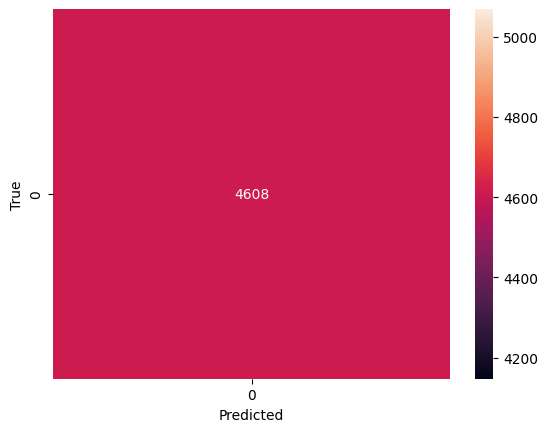

In [102]:
y_pred = model.predict(expanded_data) 
y_pred = np.argmax(y_pred, axis=1)
# Generate confusion matrix
cm = confusion_matrix(target, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

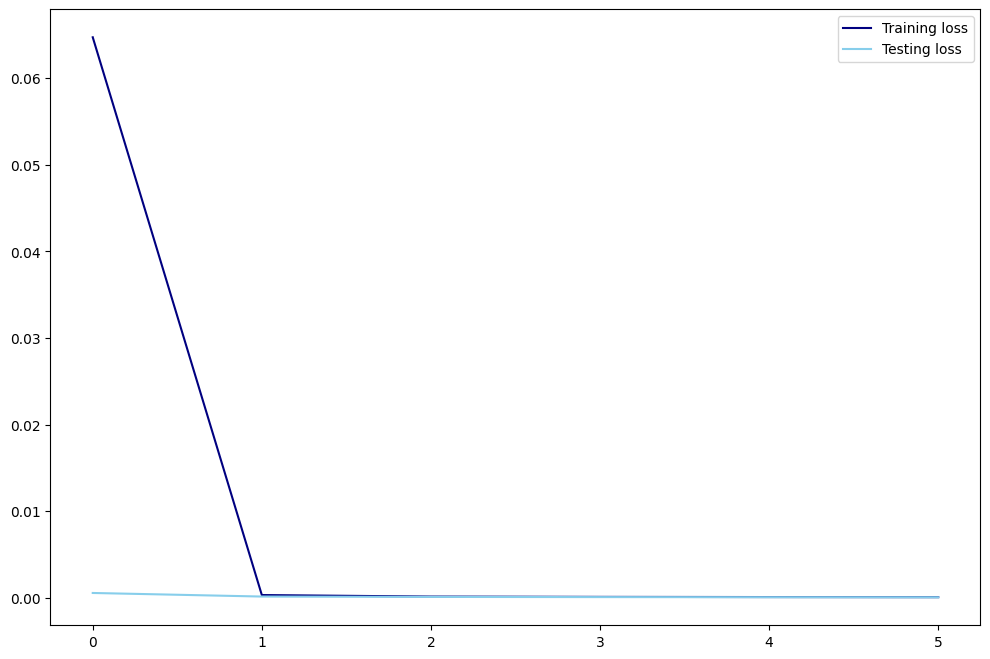

In [103]:
# Visualize the loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

In [104]:
# Get the embeddings from the embedding layer
embeddings = model.layers[0].get_weights()[0]

# Create a dictionary to map indices to words
word_to_index = tokenizer.word_index
index_to_word = {v: k for k, v in word_to_index.items()}

# Now you can get the embedding of a word like this:
word = "example"
word_embedding = embeddings[word_to_index[word]]

In [105]:
word_embedding

array([-0.02255082,  0.00700866,  0.01382455, -0.01725335, -0.0303372 ,
        0.00691848,  0.00236646,  0.00409759,  0.00865497,  0.01499956,
        0.03027492,  0.00478874,  0.05840042, -0.07341922, -0.0409423 ,
       -0.039711  , -0.00108071,  0.00610609,  0.00078649, -0.02993326,
       -0.03670822, -0.08780694,  0.04805084, -0.00472046, -0.04872473,
       -0.02216921, -0.02982769, -0.03591086, -0.04776158, -0.04431543,
       -0.02666467, -0.0507408 ,  0.0025912 , -0.01916809, -0.00159528,
       -0.00645231,  0.00669107, -0.04385322, -0.05963807,  0.05581766,
        0.01428082, -0.01353354,  0.02933353, -0.00760281,  0.01590175,
       -0.02009407,  0.02438172, -0.03350388, -0.04213658, -0.00349936,
       -0.03961281, -0.03643121, -0.02806983,  0.04405316,  0.03430193,
        0.07932195,  0.01480634,  0.0195814 ,  0.05859388, -0.03033327,
       -0.00939258,  0.02022826,  0.00991661,  0.008676  ,  0.00866315,
       -0.03844327,  0.00064403,  0.08034353, -0.01027812, -0.00